In [54]:
!pip install underthesea matplotlib==3.7.3 seaborn wordcloud jupyternotify


In [55]:
%load_ext jupyternotify


The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [56]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from underthesea import text_normalize, word_tokenize
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('content/dataset.csv', sep=';')
df['label'] = df['label'].str.replace('__label__', '', regex=False)
df.head()

,label,text
0,Khac,sinh viên sv thành tích hoạt động quản bảo hiể...
1,Dao_tao,thời gian học tập tối đa phép học đối sinh viê...
2,KTX,mật khẩu tài khoản email sinh viên sv xử lý lỗ...
3,Tot_nghiep,viên trung bình cộng thành viên hội đồng nhân ...
4,Hoc_tap_ren_luyen,học đồng thời học hai chương trình đào đánh gi...


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   649 non-null    object
 1   text    649 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


In [59]:
import unicodedata


def unicode_normalize(text):
    return unicodedata.normalize('NFC', text)

df['text'] = df['text'].apply(unicode_normalize)

df.head()

,label,text
0,Khac,sinh viên sv thành tích hoạt động quản bảo hiể...
1,Dao_tao,thời gian học tập tối đa phép học đối sinh viê...
2,KTX,mật khẩu tài khoản email sinh viên sv xử lý lỗ...
3,Tot_nghiep,viên trung bình cộng thành viên hội đồng nhân ...
4,Hoc_tap_ren_luyen,học đồng thời học hai chương trình đào đánh gi...


In [61]:
with open('lib/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.readlines()
stopwords = [word.replace('\n', '') for word in stopwords]
print(stopwords)

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu', 'bao nhiêu', 'bao nả', 'bay biến', 'biết', 'biết bao', 'biết bao nhiêu', 'biết chắc', 'biết chừng nào', 'biết mình', 'biết mấy', 'biết thế', 'biết trước', 'biết việc', 'biết đâu', 'biết đâu chừng', 'biết đâu đấy', 'biết được', 'buổi', 'buổi làm', 'buổi mới', 'buổi ngày', 'buổi sớm', 'bà', 'bà ấy', 'bài', 'bài bác', 'bài bỏ', 'bài cái', 'bác', 'bán', 'bán cấp', 'bán dạ', 'bán thế', 'bây bẩy', 'bây chừ', 'bây giờ', 'bây nhiêu', 'bèn', 'béng', 'bên', 'bên bị', 'bên có', 'bên cạnh', 'bông', 'bước', 'bước khỏi', 'bước tới', 'bước đi', 'bạn', 'bản', 'bản bộ', 'bản riêng', 'bản thân', 'bản ý', 'bất chợt', 'bất cứ', 'bất giác', 'bất kì', 'bất kể', 'bất kỳ', 'bất luận', 'bất ngờ', 'bất nhược', 'bất quá', 'bất quá chỉ', 'bất thình lình', 'bất tử', 'bất đồ', 'bấy', 'bấy chầy', 'bấy chừ', 'bấy giờ', 'bấy lâu', 'bấy lâ

In [62]:
def clean_text(text):
    pattern = r'[^a-zA-Z\sÀ-ỹ]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

df['text'] = df['text'].apply(clean_text)

df.head()

,label,text
0,Khac,sinh viên sv thành tích hoạt động quản bảo hiể...
1,Dao_tao,thời gian học tập tối đa phép học đối sinh viê...
2,KTX,mật khẩu tài khoản email sinh viên sv xử lý lỗ...
3,Tot_nghiep,viên trung bình cộng thành viên hội đồng nhân ...
4,Hoc_tap_ren_luyen,học đồng thời học hai chương trình đào đánh gi...


In [63]:
%%notify
tkn_df = df.copy()

tkn_df['text'] = tkn_df['text'].apply(lambda sentence: word_tokenize(sentence, format='text'))

tkn_df.head()

,label,text
0,Khac,sinh_viên sv thành_tích hoạt_động quản bảo_hiể...
1,Dao_tao,thời_gian học_tập tối_đa phép học đối_sinh_viê...
2,KTX,mật_khẩu tài_khoản email sinh_viên sv xử_lý lỗ...
3,Tot_nghiep,viên trung_bình cộng thành_viên hội_đồng_nhân ...
4,Hoc_tap_ren_luyen,học đồng_thời học hai chương_trình đào đánh_gi...


<IPython.core.display.Javascript object>

In [64]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]

    return ' '.join(words)

tkn_df['text'] = tkn_df['text'].apply(remove_stopwords)
tkn_df.head()

,label,text
0,Khac,sinh_viên sv thành_tích hoạt_động quản bảo_hiể...
1,Dao_tao,thời_gian học_tập tối_đa phép học đối_sinh_viê...
2,KTX,mật_khẩu tài_khoản email sinh_viên sv xử_lý lỗ...
3,Tot_nghiep,viên trung_bình cộng thành_viên hội_đồng_nhân ...
4,Hoc_tap_ren_luyen,học đồng_thời học hai chương_trình đào đánh_gi...


label
Khac                   105
Tot_nghiep              93
KTX                    117
Hoc_tap_ren_luyen       93
Khen_thuong_ky_luat     90
Dao_tao                151
Name: count, dtype: int64


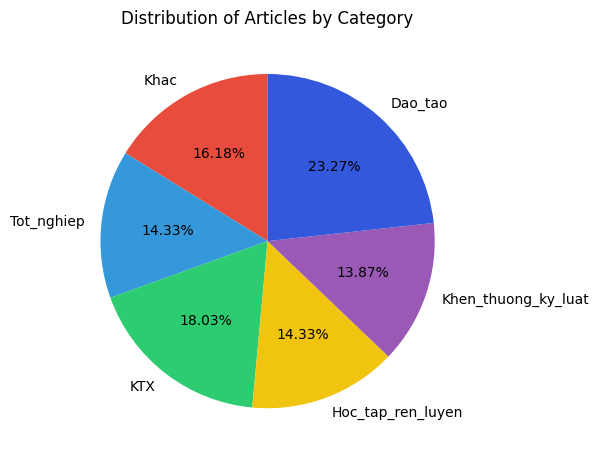

In [ ]:
temp = pd.read_csv('content/dataset.csv', sep=';')
temp['label'] = temp['label'].str.replace('__label__', '', regex=False).str.strip()

label_order = ['Dao_tao', 'Khen_thuong_ky_luat', 'Hoc_tap_ren_luyen', 'KTX', 'Tot_nghiep', 'Khac']
custom_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F1C40F', '#9B59B6', '#3458DB']


label_counts = temp['label'].value_counts()
label_counts = label_counts.reindex(label_order[::-1])

print(label_counts)


plt.figure(figsize=(6, 6))
plt.pie(label_counts.dropna(),
        labels=label_counts.dropna().index,
        autopct='%1.2f%%',
        startangle=90,
        colors=custom_colors)
plt.title('Distribution of Articles by Category')
plt.tight_layout()
plt.show()


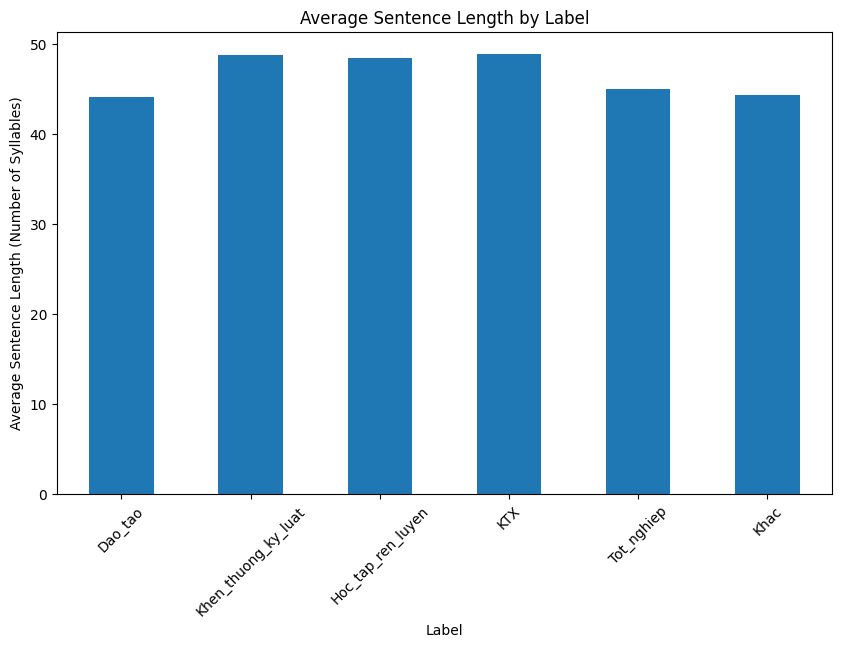

In [ ]:
temp = pd.read_csv('content/dataset.csv', sep=';')
temp['label'] = temp['label'].str.replace('__label__', '', regex=False).str.strip()

label_order = ['Dao_tao', 'Khen_thuong_ky_luat', 'Hoc_tap_ren_luyen', 'KTX', 'Tot_nghiep', 'Khac']

temp['sentence_length'] = temp['text'].apply(lambda x: len(str(x).split()))
average_sentence_length = temp.groupby('label')['sentence_length'].mean().reindex(label_order)

plt.figure(figsize=(10, 6))
average_sentence_length.plot(kind='bar')
plt.title('Average Sentence Length by Label')
plt.xlabel('Label')
plt.ylabel('Average Sentence Length (Number of Syllables)')
plt.xticks(rotation=45)
plt.show()

In [67]:
temp_tkn_df = tkn_df.copy()
temp_tkn_df['text'] = temp_tkn_df['text'].apply(lambda x: [word.replace('_', ' ') for word in x.split()])

all_words = [word for title in temp_tkn_df['text'] for word in title]
word_frequency = {}
total_titles = len(temp_tkn_df)

for word in all_words:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

word_frequencies = {word: freq / total_titles for word, freq in word_frequency.items()}

word_frequency_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency'])
word_frequency_df = word_frequency_df.sort_values(by='Frequency', ascending=False)

word_frequency_df = word_frequency_df.reset_index(drop=True)
word_frequency_df.head(50)

,Word,Frequency
0,sinh viên,0.676425
1,đào,0.375963
2,học,0.360555
3,chương trình,0.275809
4,trường,0.261941
5,đại học,0.252696
6,quy định,0.224961
7,học tập,0.206471
8,thơ,0.151002
9,thực hiện,0.130971


In [68]:
word_frequency_df.tail(10)


,Word,Frequency
1529,thuốc lá,0.001541
1530,tình trạng,0.001541
1531,quy khả năng,0.001541
1532,kỳ hạn,0.001541
1533,đối hư hỏng,0.001541
1534,toán phí,0.001541
1535,chiều,0.001541
1536,tối,0.001541
1537,tiêu chuẩn nghiệp,0.001541
1538,tối thiểu thang,0.001541


In [69]:
corpus = tkn_df.copy()
corpus['text'] = corpus['text'].astype(str)

In [70]:
vectorizer = TfidfVectorizer(min_df=10)
features = vectorizer.fit_transform(corpus['text'])

joblib.dump(vectorizer, 'tfidf.joblib')
tfidf_df = pd.DataFrame(data=features.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df['label'] = corpus['label']
tfidf_df.head(70)

,an_ninh,ban_hành,bao,buộc,bảng,bảo_vệ,bậc,bố_trí,chi_phí,chuyên_ngành,...,đăng_ký,đơn_vị,đại_học,đầu,đề_nghị,đề_xuất,đối_sinh_viên,đối_tượng,đồng_thời,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,Khac
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.266562,0.0,0.000000,Dao_tao
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,KTX
3,0.0,0.0,0.0,0.0,0.0,0.398656,0.0,0.0,0.0,0.0,...,0.0000,0.266821,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,Tot_nghiep
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.369268,0.000000,0.0,0.0,0.0,0.000000,0.0,0.231270,Hoc_tap_ren_luyen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.147212,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,Hoc_tap_ren_luyen
66,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.2579,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,Khac
67,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,Dao_tao
68,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0000,0.000000,0.167212,0.0,0.0,0.0,0.000000,0.0,0.273662,Khac


In [71]:
train_df, temp_df = train_test_split(tfidf_df, test_size=0.2, stratify=tfidf_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_df.to_csv('content/train_df.csv', index=False)
val_df.to_csv('content/val_df.csv', index=False)
test_df.to_csv('content/test_df.csv', index=False)

In [72]:
%%notify
train_df = pd.read_csv('content/train_df.csv')
val_df = pd.read_csv('content/val_df.csv')
test_df = pd.read_csv('content/test_df.csv')

X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']


<IPython.core.display.Javascript object>

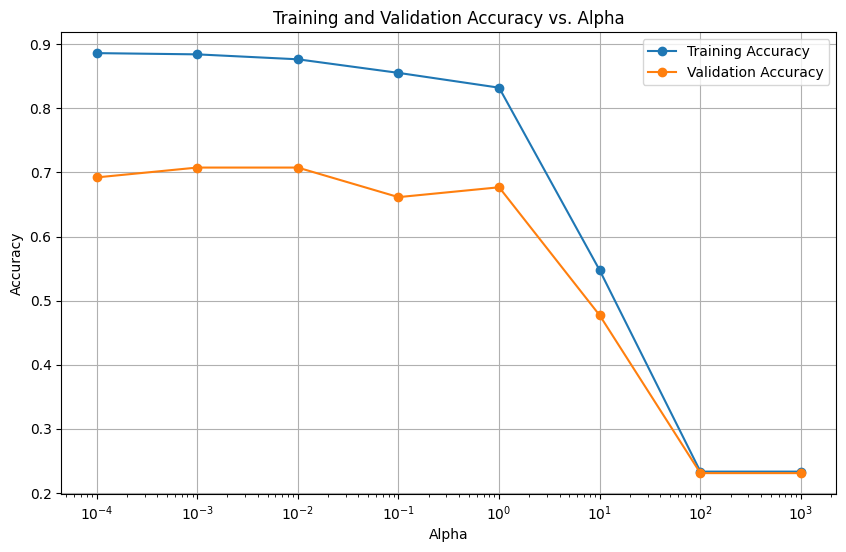

In [73]:
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(alpha_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Alpha')
plt.grid(True)
plt.legend()
plt.show()


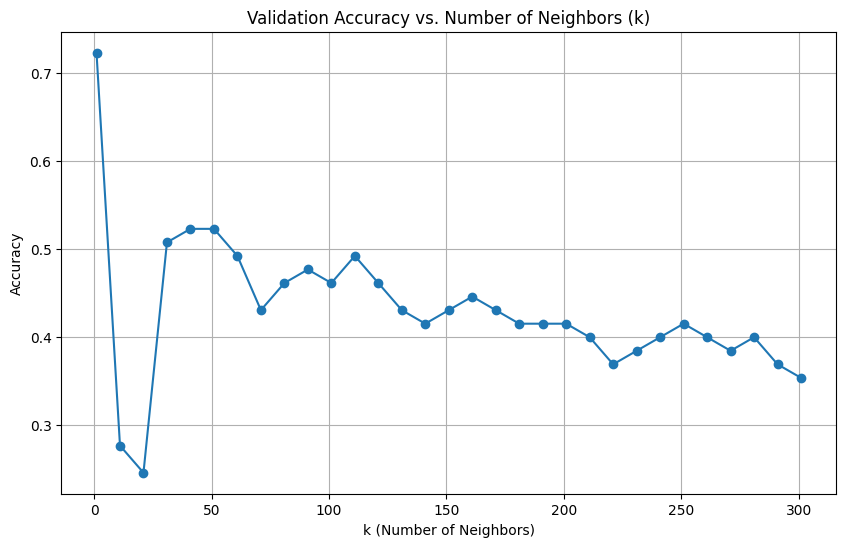

<IPython.core.display.Javascript object>

In [74]:
%%notify
k_values = range(1, 302, 10)
validation_accuracies = []

with joblib.parallel_backend('loky'):
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()

In [75]:
%%notify
param_grid = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

results = []

for weight in param_grid['weights']:
    for metric in param_grid['metric']:
        with joblib.parallel_backend('loky'):
            clf = KNeighborsClassifier(n_neighbors=101, weights=weight, metric=metric, n_jobs=-1)

            clf.fit(X_train, y_train)

            y_val_pred = clf.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)

            results.append({
                'weights': weight,
                'distance_metric': metric,
                'accuracy': accuracy
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)

display(results_df)

,weights,distance_metric,accuracy
0,distance,cosine,0.630769
1,distance,euclidean,0.507692
2,uniform,cosine,0.476923
3,uniform,euclidean,0.461538
4,distance,manhattan,0.446154
5,uniform,manhattan,0.369231


<IPython.core.display.Javascript object>

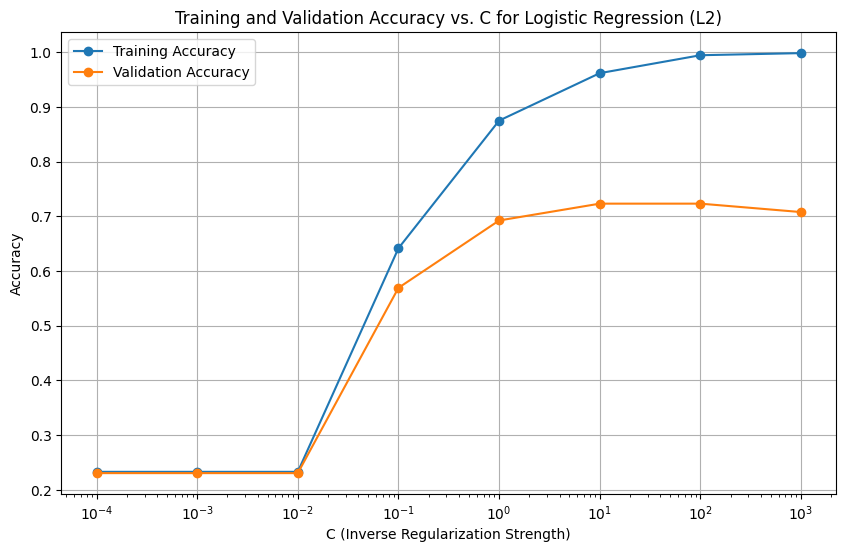

In [76]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    with joblib.parallel_backend('loky'):
        clf = LogisticRegression(C=C, max_iter=10000, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Logistic Regression (L2)')
plt.grid(True)
plt.legend()
plt.show()

d:\Anaconda\envs\NCKH\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda\envs\NCKH\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Anaconda\envs\NCKH\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


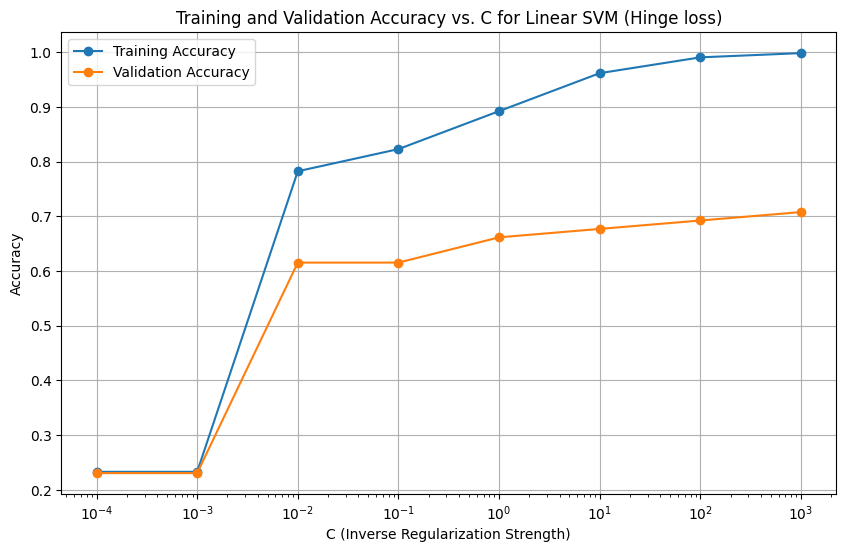

<IPython.core.display.Javascript object>

In [77]:
%%notify
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
validation_accuracies = []

for C in C_values:
    clf = LinearSVC(C=C, loss='hinge', max_iter=10000)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))

    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.semilogx(C_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(C_values, validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. C for Linear SVM (Hinge loss)')
plt.grid(True)
plt.legend()
plt.show()

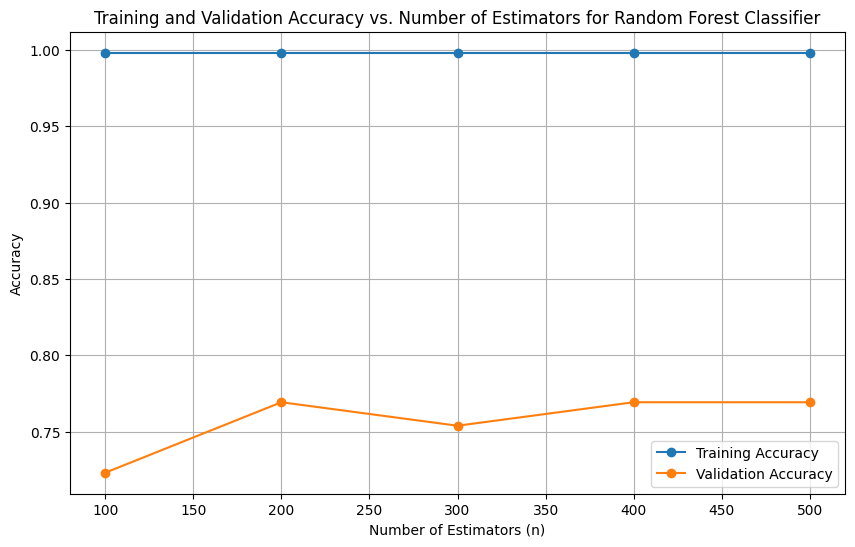

<IPython.core.display.Javascript object>

In [78]:
%%notify
n_values = range(100, 501, 100)
train_accuracies = []
validation_accuracies = []

for n in n_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Estimators for Random Forest Classifier')
plt.grid(True)
plt.legend()
plt.show()

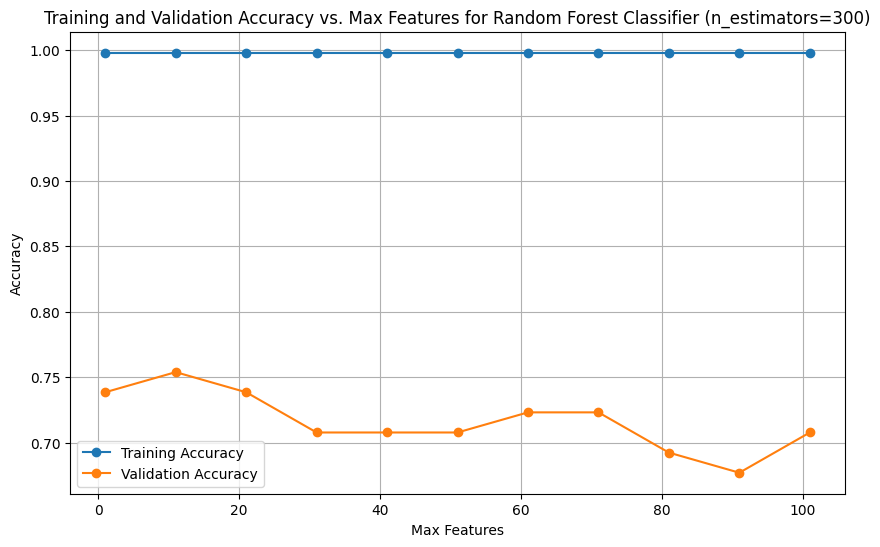

<IPython.core.display.Javascript object>

In [79]:
%%notify
max_features_values = range(1, 102, 10)
train_accuracies = []
validation_accuracies = []

for max_features in max_features_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=max_features, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_features_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(max_features_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Features for Random Forest Classifier (n_estimators=300)')
plt.grid(True)
plt.legend()
plt.show()

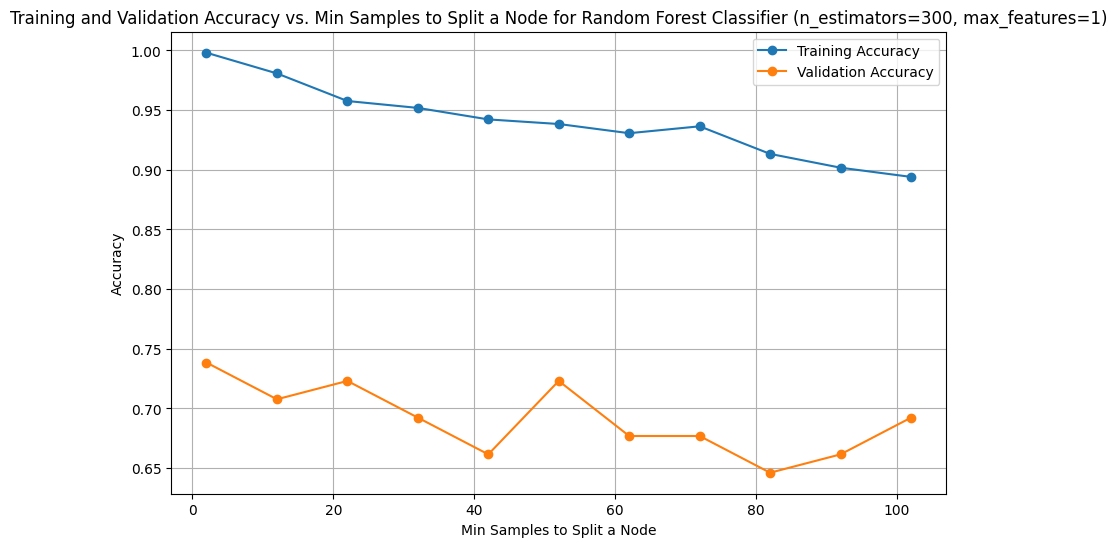

<IPython.core.display.Javascript object>

In [80]:
%%notify
min_samples_split_values = range(2, 103, 10)
train_accuracies = []
validation_accuracies = []

for min_samples_split in min_samples_split_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=min_samples_split, n_jobs=-1)
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(min_samples_split_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Min Samples to Split a Node')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Min Samples to Split a Node for Random Forest Classifier (n_estimators=300, max_features=1)')
plt.grid(True)
plt.legend()
plt.show()

Number of training samples: 519
Number of validation samples: 65
Number of test samples: 65

Distribution of labels in training set:
Counter({'Dao_tao': 121, 'KTX': 94, 'Khac': 84, 'Hoc_tap_ren_luyen': 74, 'Tot_nghiep': 74, 'Khen_thuong_ky_luat': 72})

Distribution of labels in validation set:
Counter({'Dao_tao': 15, 'KTX': 12, 'Khac': 10, 'Tot_nghiep': 10, 'Hoc_tap_ren_luyen': 9, 'Khen_thuong_ky_luat': 9})

Distribution of labels in test set:
Counter({'Dao_tao': 15, 'KTX': 11, 'Khac': 11, 'Hoc_tap_ren_luyen': 10, 'Tot_nghiep': 9, 'Khen_thuong_ky_luat': 9})


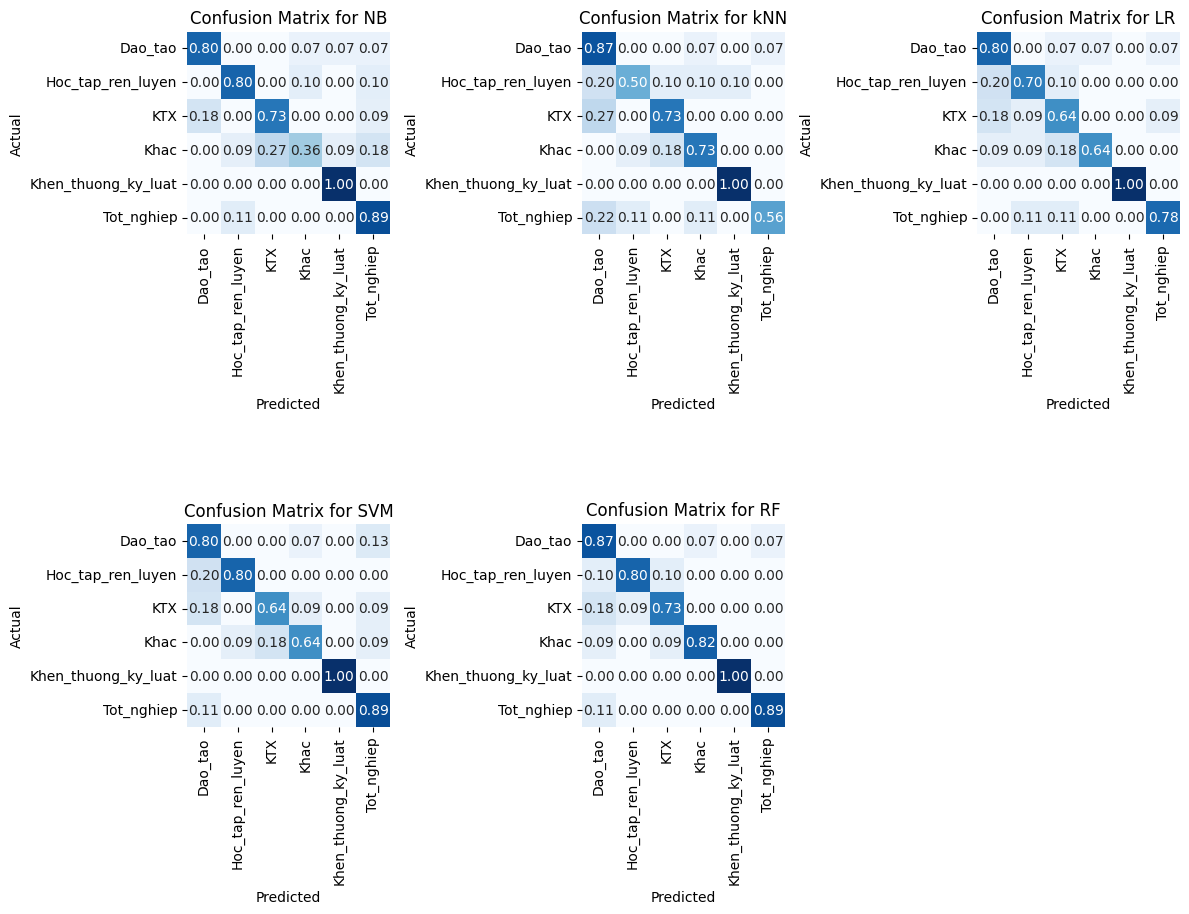

,Parameters,Accuracy,Precision,Recall,F1 Score,Training Time (s),Testing Time (ms)
NB,"{'alpha': 0.1, 'class_prior': None, 'fit_prior...",75.38%,0.7553,0.7538,0.7421,0.00,2.00
kNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",73.85%,0.7460,0.7385,0.7316,0.00,33.91
LR,"{'C': 10, 'class_weight': None, 'dual': False,...",75.38%,0.7635,0.7538,0.7546,0.03,1.13
SVM,"{'C': 1, 'class_weight': None, 'dual': 'auto',...",78.46%,0.7937,0.7846,0.7835,0.01,1.52
RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",84.62%,0.8526,0.8462,0.8469,0.20,44.52


In [81]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from joblib import parallel_backend
import joblib
from collections import Counter

# Print the number of samples in each set
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of validation samples: {X_val.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")

# Print the distribution of labels in each set
print("\nDistribution of labels in training set:")
print(Counter(y_train))

print("\nDistribution of labels in validation set:")
print(Counter(y_val))

print("\nDistribution of labels in test set:")
print(Counter(y_test))

clf0 = MultinomialNB(alpha=0.1)
clf1 = KNeighborsClassifier(n_neighbors=101, weights='distance', metric='cosine', n_jobs=-1)
clf2 = LogisticRegression(C=10, max_iter=10000, n_jobs=-1)
clf3 = LinearSVC(C=1, loss='hinge', max_iter=10000)
clf4 = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=12, n_jobs=-1)

classifiers = [clf0, clf1, clf2, clf3, clf4]
classifier_labels = ['NB', 'kNN', 'LR', 'SVM', 'RF']

training_times = []
testing_times = []
accuracies = []
confusion_matrices = []
precisions = []
recalls = []
f1_scores = []

for i, clf in enumerate(classifiers):
    with joblib.parallel_backend('loky'):
        start_time1 = time.time()
        clf.fit(X_train, y_train)
        end_time1 = time.time()
        training_time = end_time1 - start_time1
        training_times.append(training_time)

        start_time2 =time.time()
        y_pred = clf.predict(X_test)
        end_time2 = time.time()
        testing_time = (end_time2 - start_time2)  * 1000  # Convert to milliseconds
        testing_times.append(testing_time)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        confusion = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(confusion)

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

plt.figure(figsize=(12, 10))

for i, clf_label in enumerate(classifier_labels):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cbar=False, cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, square=True)
    plt.title(f'Confusion Matrix for {clf_label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

test_results = {
    'Parameters': [str(clf.get_params()) for clf in classifiers],
    'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
    'Precision': [f'{prec:.4f}' for prec in precisions],
    'Recall': [f'{rec:.4f}' for rec in recalls],
    'F1 Score': [f'{f1:.4f}' for f1 in f1_scores],
    'Training Time (s)': [f'{time:.2f}' for time in training_times],
    'Testing Time (ms)': [f'{time:.2f}' for time in testing_times]
}

display(pd.DataFrame(test_results, index=classifier_labels))
results_df = pd.DataFrame(test_results, index=classifier_labels)
results_df.to_excel("result/sklearn_results.xlsx", index=True)